In [ ]:
#逻辑，用routes的航线中的机场代码，匹配机场airports.dat中的数据- 这个数据中第五列是IATA代码，第三列是城市的名称，可以相对应，然后建立有向网络
#后期如果不需要可以换成无向网络，然后边就是航线，边的属性就是（航空公司，起点和重点的IATA代码，距离，中转次数）
#另外需要各个城市的地理坐标（后续用来绘制航线图）
#然后合并边，看看是不是属于一个城市的，（比如我知道的有的城市有2个机场，例如上海），这种情况下合并为一个节点，但是边不合并，各自连接到新的节点上
#至于如何区分，可以通过边的属性区分

In [31]:
# #wiki百科爬机场数据代码（到时候直接变成markdown代码的形式）
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd

# # 目标URL
# url = "https://en.wikipedia.org/wiki/List_of_international_airports_by_country"

# # 请求网页内容
# response = requests.get(url)
# soup = BeautifulSoup(response.content, "html.parser")

# # 初始化列表用于存储数据
# data = {
#     "Country": [],
#     "Airport": [],
#     "IATA Code": []
# }

# # 遍历每个国家的机场信息表格
# for table in soup.find_all("table", {"class": "wikitable"}):
#     country = None  # 初始化国家名
#     for row in table.find_all("tr")[1:]:  # 跳过表头行
#         cells = row.find_all("td")
        
#         # 判断是否为国家行（通常包含 3 列）
#         if len(cells) == 3:
#             country = cells[0].text.strip()
#             airport = cells[1].text.strip()
#             iata_code = cells[2].text.strip()
#         elif len(cells) == 2:  # 如果只有两列，使用前面的国家名
#             airport = cells[0].text.strip()
#             iata_code = cells[1].text.strip()
        
#         # 添加数据到列表
#         if country and airport and iata_code:
#             data["Country"].append(country)
#             data["Airport"].append(airport)
#             data["IATA Code"].append(iata_code)

# # 转换为DataFrame
# df = pd.DataFrame(data)

# # 显示或保存数据
# print(df)
# # df.to_csv("international_airports.csv", index=False) # 保存为CSV文件

In [33]:
# #得到航线代码的文件的代码，同理markdown代码的形式
# import requests

# # URL of the routes.dat file
# url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

# # 目标文件路径
# file_path = "airports.dat"

# try:
#     # 发送GET请求
#     response = requests.get(url)
#     response.raise_for_status()  # 检查请求是否成功

#     # 将内容写入文件
#     with open(file_path, "wb") as file:
#         file.write(response.content)
#     print(f"文件已成功下载并保存为 {file_path}")

# except requests.exceptions.RequestException as e:
#     print(f"下载文件时出错: {e}")

In [35]:
#第一步，处理数据，用IATA链接城市，新城新的完整的文件

In [37]:
import pandas as pd

In [39]:
# 读取 airports.dat 文件
airports_df = pd.read_csv("airports.dat", header=None, encoding="utf-8", names=[
    "ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude",
    "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"
])

In [41]:
# 读取 routes.dat 文件
routes_df = pd.read_csv("routes.dat", header=None, encoding="utf-8", names=[
    "Airline", "AirlineID", "SourceIATA", "SourceAirportID", "DestinationIATA",
    "DestinationAirportID", "Codeshare", "Stops", "Equipment"
])

In [43]:
# 创建 IATA 到城市名称的映射
iata_to_city = dict(zip(airports_df["IATA"], airports_df["City"]))

# 添加起点城市列
routes_df["SourceCity"] = routes_df["SourceIATA"].map(iata_to_city)

# 添加终点城市列
routes_df["DestinationCity"] = routes_df["DestinationIATA"].map(iata_to_city)

# 保存到新的 CSV 文件
routes_df.to_csv("routes_with_cities.csv", index=False, encoding="utf-8")

print("routes_with_cities.csv completed")

routes_with_cities.csv completed


In [45]:
#更新城市经纬度坐标在这个routes_with_cities.csv文件中

In [47]:
iata_to_coords = dict(zip(airports_df["IATA"], zip(airports_df["Latitude"], airports_df["Longitude"])))

In [49]:
routes_df["SourceLatitude"] = routes_df["SourceIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[0])
routes_df["SourceLongitude"] = routes_df["SourceIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[1])


In [51]:
routes_df["DestinationLatitude"] = routes_df["DestinationIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[0])
routes_df["DestinationLongitude"] = routes_df["DestinationIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[1])


In [53]:
# 保存到新的 CSV 文件
routes_df.to_csv("routes_with_cities_and_coords.csv", index=False, encoding="utf-8")

print("routes_with_cities_and_coords.csv completed")


routes_with_cities_and_coords.csv completed


In [55]:
#下面的代码是开始构建网络了

In [57]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [58]:
import networkx as nx
from geopy.distance import geodesic

In [59]:
routes_df = pd.read_csv("routes_with_cities_and_coords.csv", encoding="utf-8")

In [61]:
G = nx.MultiDiGraph()#允许两点之间存在多条边，因为边的属性不一样

In [65]:
missing_city_count = 0  # 缺失城市行数
missing_coords_count = 0  # 缺失坐标行数
total_rows = len(routes_df)  # 总航线行数

In [67]:
# 遍历数据集，逐行添加边
for _, row in routes_df.iterrows():
    source_city = row["SourceCity"]
    destination_city = row["DestinationCity"]

    # 跳过无效的行（缺少城市）
    if pd.isna(source_city) or pd.isna(destination_city):
        missing_city_count += 1
        continue
    # 检查并添加 Source 节点
    if source_city not in G.nodes:
        G.add_node(
            source_city,
            latitude=row["SourceLatitude"] if not pd.isna(row["SourceLatitude"]) else None,
            longitude=row["SourceLongitude"] if not pd.isna(row["SourceLongitude"]) else None
        )

    # 检查并添加 Destination 节点
    if destination_city not in G.nodes:
        G.add_node(
            destination_city,
            latitude=row["DestinationLatitude"] if not pd.isna(row["DestinationLatitude"]) else None,
            longitude=row["DestinationLongitude"] if not pd.isna(row["DestinationLongitude"]) else None
        )

    # 边的属性（用 None 替代缺失值）
    airline = row.get("Airline", None)
    source_iata = row.get("SourceIATA", None)
    destination_iata = row.get("DestinationIATA", None)
    stops = row.get("Stops", None)
    equipment = row.get("Equipment", None)

    # 计算距离（处理缺失经纬度的情况）
    try:
        source_coords = (row["SourceLatitude"], row["SourceLongitude"])
        destination_coords = (row["DestinationLatitude"], row["DestinationLongitude"])
        distance = geodesic(source_coords, destination_coords).kilometers
    except (ValueError, TypeError):
        distance = None

    # 添加边到图中，每行数据对应一条边
    G.add_edge(
        source_city,
        destination_city,
        key=(airline, source_iata, destination_iata),  # 唯一标识符
        airline=airline,
        source_iata=source_iata,
        destination_iata=destination_iata,
        distance=distance,
        stops=stops,
        equipment=equipment
    )


In [69]:
# 保存网络到 GraphML 格式
nx.write_graphml(G, "airline_network.graphml")
print("Network has been saved to 'airline_network.graphml'.")


Network has been saved to 'airline_network.graphml'.


In [71]:
# 打印过滤统计信息（中文）
print(f"total airline: {total_rows}")
print(f"missing cities rows: {missing_city_count}")
print(f"missing coords rows: {missing_coords_count}")

# 打印网络的基本信息（中文）
print(f"nodes: {G.number_of_nodes()}")
print(f"edges: {G.number_of_edges()}")


total airline: 67663
missing cities rows: 733
missing coords rows: 0
nodes: 3135
edges: 66930


In [73]:
#below 是 degree distribution分析

nodes: 3135
edges: 66930
average in-degree: 21.35
average out-degree: 21.35
max in-degree: 1224
max out-degree: 1232


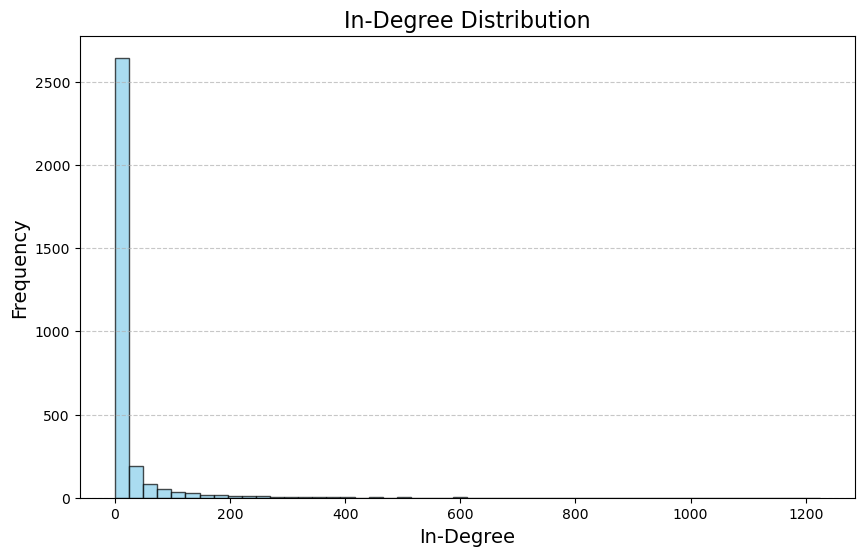

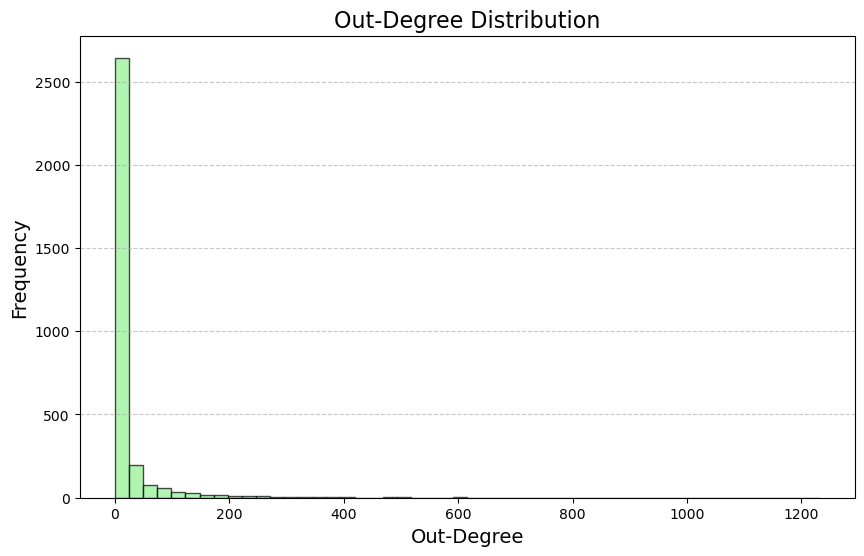

In [75]:
import matplotlib.pyplot as plt

# 计算入度和出度
in_degrees = [deg for _, deg in G.in_degree()]  # 节点的入度列表
out_degrees = [deg for _, deg in G.out_degree()]  # 节点的出度列表

# 打印关键统计信息
print(f"nodes: {G.number_of_nodes()}")  # 网络中的节点数量
print(f"edges: {G.number_of_edges()}")  # 网络中的边数量
print(f"average in-degree: {sum(in_degrees) / len(in_degrees):.2f}")  # 平均入度
print(f"average out-degree: {sum(out_degrees) / len(out_degrees):.2f}")  # 平均出度
print(f"max in-degree: {max(in_degrees)}")  # 最大入度
print(f"max out-degree: {max(out_degrees)}")  # 最大出度

# 绘制入度分布图
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=50, color="skyblue", edgecolor="black", alpha=0.7)  # 入度分布
plt.title("In-Degree Distribution", fontsize=16)  # 标题
plt.xlabel("In-Degree", fontsize=14)  # x轴标签
plt.ylabel("Frequency", fontsize=14)  # y轴标签
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 网格线
plt.show()

# 绘制出度分布图
plt.figure(figsize=(10, 6))
plt.hist(out_degrees, bins=50, color="lightgreen", edgecolor="black", alpha=0.7)  # 出度分布
plt.title("Out-Degree Distribution", fontsize=16)  # 标题
plt.xlabel("Out-Degree", fontsize=14)  # x轴标签
plt.ylabel("Frequency", fontsize=14)  # y轴标签
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 网格线
plt.show()


In [77]:
#应组员刘老师要求 画一个散点图

In [ ]:
pip install matplotlib networkx

In [ ]:
pip install numpy

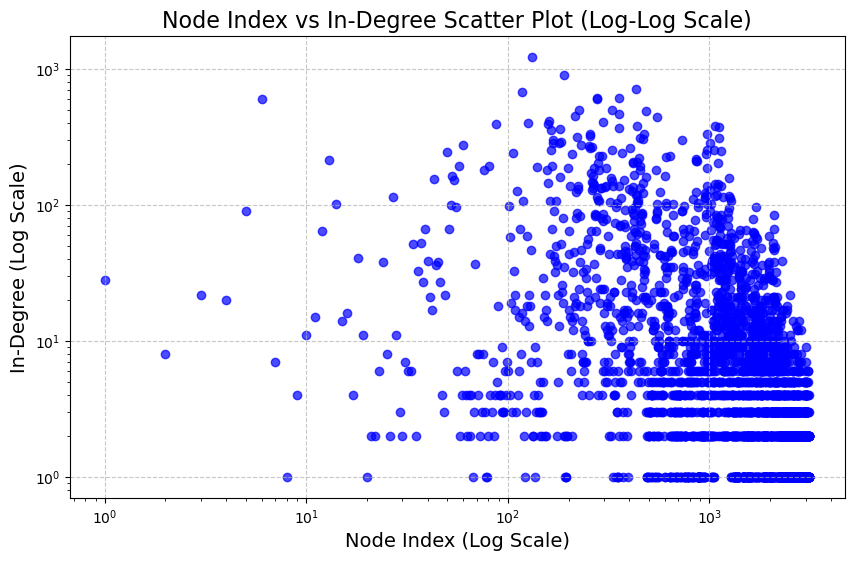

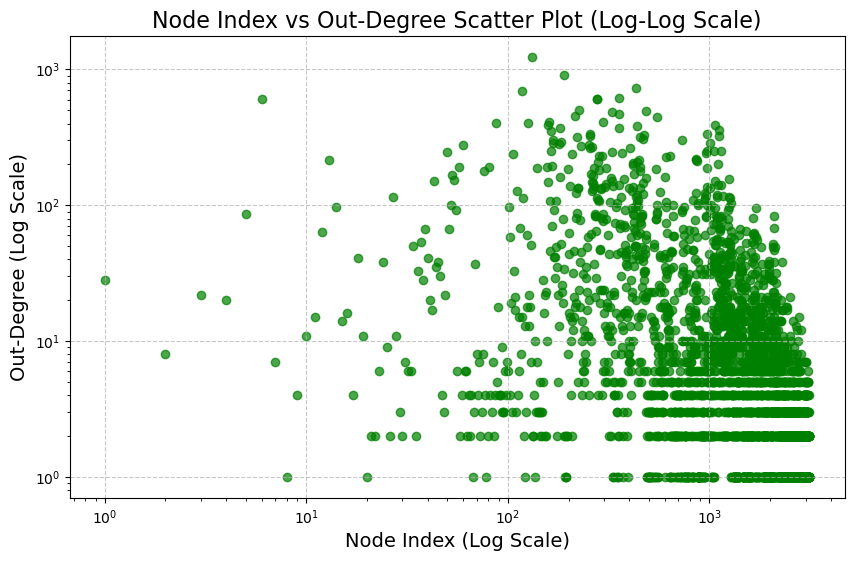

In [79]:
import matplotlib.pyplot as plt
import networkx as nx

# 假设 G 是你的 NetworkX 图
# G = ...

# 计算入度和出度
in_degrees = [deg for _, deg in G.in_degree()]  # 节点的入度列表
out_degrees = [deg for _, deg in G.out_degree()]  # 节点的出度列表
nodes = range(len(in_degrees))  # 节点编号（用于 x 轴）

# 绘制节点编号 vs 入度的散点图（双对数）
plt.figure(figsize=(10, 6))
plt.scatter(nodes, in_degrees, alpha=0.7, color="blue")  # 入度散点图
plt.xscale('log')  # 设置x轴为对数尺度
plt.yscale('log')  # 设置y轴为对数尺度
plt.title("Node Index vs In-Degree Scatter Plot (Log-Log Scale)", fontsize=16)  # 标题
plt.xlabel("Node Index (Log Scale)", fontsize=14)  # x轴标签
plt.ylabel("In-Degree (Log Scale)", fontsize=14)  # y轴标签
plt.grid(linestyle="--", alpha=0.7)  # 网格线
plt.show()

# 绘制节点编号 vs 出度的散点图（双对数）
plt.figure(figsize=(10, 6))
plt.scatter(nodes, out_degrees, alpha=0.7, color="green")  # 出度散点图
plt.xscale('log')  # 设置x轴为对数尺度
plt.yscale('log')  # 设置y轴为对数尺度
plt.title("Node Index vs Out-Degree Scatter Plot (Log-Log Scale)", fontsize=16)  # 标题
plt.xlabel("Node Index (Log Scale)", fontsize=14)  # x轴标签
plt.ylabel("Out-Degree (Log Scale)", fontsize=14)  # y轴标签
plt.grid(linestyle="--", alpha=0.7)  # 网格线
plt.show()

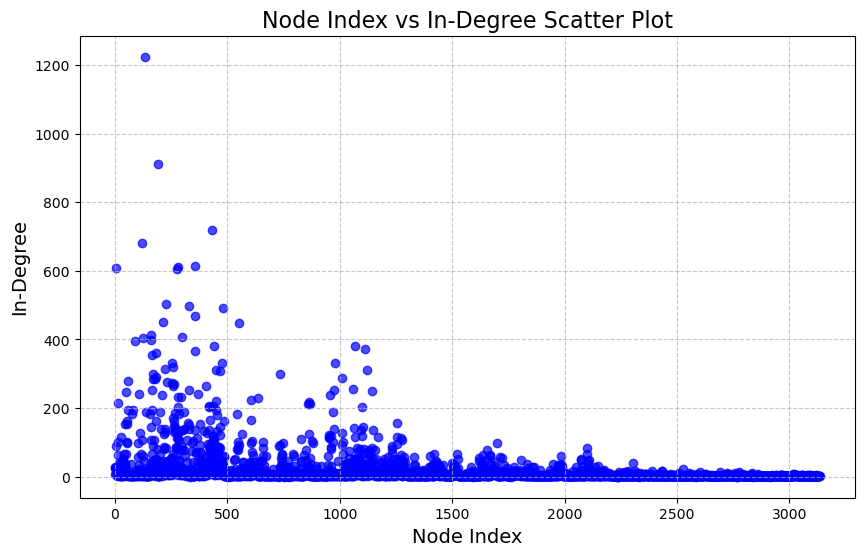

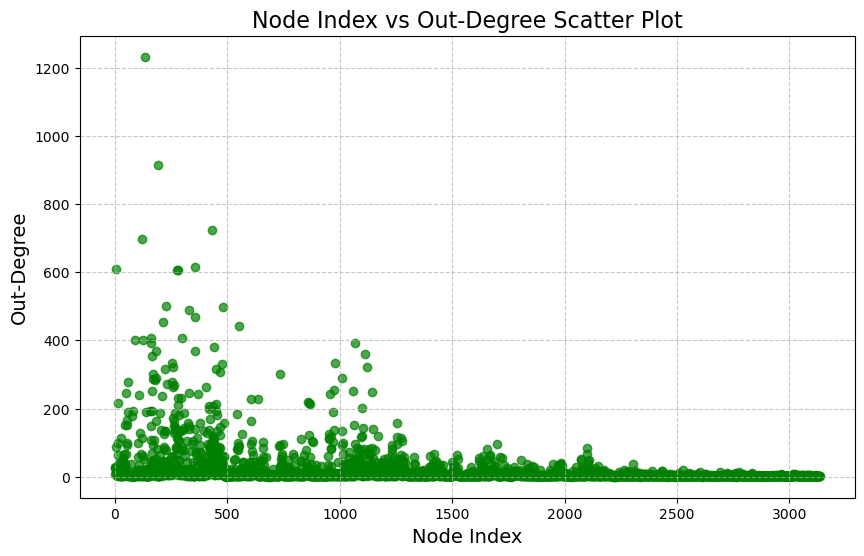

In [81]:
# 计算入度和出度
in_degrees = [deg for _, deg in G.in_degree()]  # 节点的入度列表
out_degrees = [deg for _, deg in G.out_degree()]  # 节点的出度列表
nodes = range(len(in_degrees))  # 节点编号（用于 x 轴）

# 绘制节点编号 vs 入度的散点图
plt.figure(figsize=(10, 6))
plt.scatter(nodes, in_degrees, alpha=0.7, color="blue")  # 入度散点图
plt.title("Node Index vs In-Degree Scatter Plot", fontsize=16)  # 标题
plt.xlabel("Node Index", fontsize=14)  # x轴标签
plt.ylabel("In-Degree", fontsize=14)  # y轴标签
plt.grid(linestyle="--", alpha=0.7)  # 网格线
plt.show()

# 绘制节点编号 vs 出度的散点图
plt.figure(figsize=(10, 6))
plt.scatter(nodes, out_degrees, alpha=0.7, color="green")  # 出度散点图
plt.title("Node Index vs Out-Degree Scatter Plot", fontsize=16)  # 标题
plt.xlabel("Node Index", fontsize=14)  # x轴标签
plt.ylabel("Out-Degree", fontsize=14)  # y轴标签
plt.grid(linestyle="--", alpha=0.7)  # 网格线
plt.show()


In [83]:
#可视化网络，来点震撼的

In [85]:
# 检查前几个节点的经纬度信息
for node in list(G.nodes)[:5]:
    print(f"City: {node}, Latitude: {G.nodes[node].get('latitude')}, Longitude: {G.nodes[node].get('longitude')}")


City: Sochi, Latitude: 43.449902, Longitude: 39.9566
City: Kazan, Latitude: 55.606201171875, Longitude: 49.278701782227
City: Astrakhan, Latitude: 46.2832984924, Longitude: 48.0063018799
City: Mineralnye Vody, Latitude: 44.22510147094727, Longitude: 43.08190155029297
City: Chelyabinsk, Latitude: 55.305801, Longitude: 61.5033


In [87]:
# 筛选出边属性包含 "747" 或 "767" 的边,货运航线
matching_edges = [
    edge for edge in G.edges(data=True) 
    if isinstance(edge[2].get('equipment'), str) and ('747' in edge[2]['equipment'] or '767' in edge[2]['equipment'])
]

# 打印匹配的边数量
print(f"Number of edges with '747' or '767' in equipment: {len(matching_edges)}")

# 可选：打印一些匹配的边
for edge in matching_edges[:10]:  # 打印前 10 条匹配的边
    print(edge)


Number of edges with '747' or '767' in equipment: 527
('Sochi', 'Tashkent', {'airline': 'HY', 'source_iata': 'AER', 'destination_iata': 'TAS', 'distance': 2415.716876027808, 'stops': 0, 'equipment': '767'})
('Moscow', 'Tashkent', {'airline': 'HY', 'source_iata': 'DME', 'destination_iata': 'TAS', 'distance': 2771.1966418582924, 'stops': 0, 'equipment': '764 767'})
('Moscow', 'London', {'airline': 'BA', 'source_iata': 'DME', 'destination_iata': 'LHR', 'distance': 2553.233136015182, 'stops': 0, 'equipment': '767 321 744'})
('Moscow', 'Shanghai', {'airline': 'MU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'})
('Moscow', 'Shanghai', {'airline': 'SU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'})
('Moscow', 'Male', {'airline': 'UN', 'source_iata': 'VKO', 'destination_iata': 'MLE', 'distance': 6552.335886336193, 'stops': 0, 'equipment': '74E 767

In [89]:
import plotly.graph_objects as go
import plotly.io as pio

# 设置渲染器为 notebook
pio.renderers.default = "notebook"

# 提取节点经纬度
node_longitudes = [G.nodes[node].get('longitude') for node in G.nodes if G.nodes[node].get('longitude') is not None]
node_latitudes = [G.nodes[node].get('latitude') for node in G.nodes if G.nodes[node].get('latitude') is not None]

# 提取边的经纬度
edge_longitudes_green = []  # 用于普通边（绿色）
edge_latitudes_green = []

edge_longitudes_blue = []  # 用于设备包含 "747" 或 "767" 的边（蓝色）
edge_latitudes_blue = []

for edge in G.edges(data=True):
    source = edge[0]
    target = edge[1]
    attributes = edge[2]  # 获取边的属性
    
    # 获取起点和终点的经纬度
    source_lon = G.nodes[source].get('longitude')
    source_lat = G.nodes[source].get('latitude')
    target_lon = G.nodes[target].get('longitude')
    target_lat = G.nodes[target].get('latitude')
    
    # 如果经纬度完整，添加到边的列表中
    if None not in (source_lon, source_lat, target_lon, target_lat):
        # 根据设备属性决定边的颜色
        equipment = attributes.get('equipment', "")
        if isinstance(equipment, str) and ('747' in equipment or '767' in equipment):
            edge_longitudes_blue += [source_lon, target_lon, None]  # 蓝色边
            edge_latitudes_blue += [source_lat, target_lat, None]
        else:
            edge_longitudes_green += [source_lon, target_lon, None]  # 绿色边
            edge_latitudes_green += [source_lat, target_lat, None]

# 创建节点的散点图
node_trace = go.Scattergeo(
    lon=node_longitudes,
    lat=node_latitudes,
    mode='markers',
    marker=dict(size=3, color='purple', opacity=0.8), 
    name='Nodes'
)

# 创建普通边的线图（绿色）
edge_trace_green = go.Scattergeo(
    lon=edge_longitudes_green,
    lat=edge_latitudes_green,
    mode='lines',
    line=dict(width=0.04, color='green'), 
    name='Edges (Normal)'
)

# 创建特定设备边的线图（蓝色）
edge_trace_blue = go.Scattergeo(
    lon=edge_longitudes_blue,
    lat=edge_latitudes_blue,
    mode='lines',
    line=dict(width=0.2, color='blue'), 
    name='Edges (Cargo)'
)

# 创建地球图
fig = go.Figure()
fig.add_trace(edge_trace_green)
fig.add_trace(edge_trace_blue)
fig.add_trace(node_trace)

fig.update_geos(
    showcoastlines=True,
    showcountries=True,
    showland=True,
    resolution=110,  # 地图细节分辨率
    landcolor="rgb(243, 243, 243)",  # 地面颜色
    countrycolor="rgb(200, 200, 200)",  # 国家边界颜色
    projection_type="orthographic",  # 地球投影类型
    showocean=True,
    oceancolor="rgb(230, 245, 255)"  # 海洋颜色
)

# 更新布局以增加图的大小，并移动图例
fig.update_layout(
    title="3D Global Network Visualization with Realistic Map",
    title_x=0.5,
    showlegend=True,
    width=1200,  # 增大图宽度
    height=800,  # 增大图高度
    legend=dict(
        x=0.1,  # 调整图例水平位置
        y=0.9,  # 调整图例垂直位置
        bgcolor="rgba(255, 255, 255, 0.7)",  # 设置背景色和透明度
        bordercolor="black",  # 设置边框颜色
        borderwidth=1  # 设置边框宽度
    )
)

# 显示图像
fig.show(renderer="iframe")  # 使用 iframe 渲染器


In [90]:
#提取枢纽城市
# 计算阈值（前5%的节点）
total_degrees = [in_deg + out_deg for in_deg, out_deg in zip(in_degrees, out_degrees)]
threshold = sorted(total_degrees, reverse=True)[int(len(total_degrees) * 0.05)]

# 提取枢纽机场
hub_airports = [node for node, deg in G.degree() if deg >= threshold]

print(f"Threshold for hub airports: {threshold}")
print(f"Number of hub airports: {len(hub_airports)}")

Threshold for hub airports: 202
Number of hub airports: 158


In [93]:
#枢纽节点，用黄色星号代替
import plotly.graph_objects as go
import plotly.io as pio

# 设置渲染器为 notebook
pio.renderers.default = "notebook"

# 提取普通节点和枢纽节点的经纬度
threshold_degree = 100  # 假设枢纽节点的阈值为度数大于100
hub_nodes = [node for node, degree in G.degree() if degree > threshold_degree]

node_longitudes = [G.nodes[node].get('longitude') for node in G.nodes if G.nodes[node].get('longitude') is not None and node not in hub_nodes]
node_latitudes = [G.nodes[node].get('latitude') for node in G.nodes if G.nodes[node].get('latitude') is not None and node not in hub_nodes]

hub_longitudes = [G.nodes[node].get('longitude') for node in hub_nodes if G.nodes[node].get('longitude') is not None]
hub_latitudes = [G.nodes[node].get('latitude') for node in hub_nodes if G.nodes[node].get('latitude') is not None]

# 提取边的经纬度
edge_longitudes_green = []  # 普通边（绿色）
edge_latitudes_green = []

edge_longitudes_blue = []  # 特定设备边（蓝色）
edge_latitudes_blue = []

for edge in G.edges(data=True):
    source = edge[0]
    target = edge[1]
    attributes = edge[2]  # 获取边的属性
    
    # 获取起点和终点的经纬度
    source_lon = G.nodes[source].get('longitude')
    source_lat = G.nodes[source].get('latitude')
    target_lon = G.nodes[target].get('longitude')
    target_lat = G.nodes[target].get('latitude')
    
    # 如果经纬度完整，添加到边的列表中
    if None not in (source_lon, source_lat, target_lon, target_lat):
        # 根据设备属性决定边的颜色
        equipment = attributes.get('equipment', "")
        if isinstance(equipment, str) and ('747' in equipment or '767' in equipment):
            edge_longitudes_blue += [source_lon, target_lon, None]  # 蓝色边
            edge_latitudes_blue += [source_lat, target_lat, None]
        else:
            edge_longitudes_green += [source_lon, target_lon, None]  # 绿色边
            edge_latitudes_green += [source_lat, target_lat, None]

# 创建普通节点的散点图
node_trace = go.Scattergeo(
    lon=node_longitudes,
    lat=node_latitudes,
    mode='markers',
    marker=dict(size=3, color='purple', opacity=0.8), 
    name='Nodes'
)

# 创建枢纽节点的散点图（星星符号）
hub_trace = go.Scattergeo(
    lon=hub_longitudes,
    lat=hub_latitudes,
    mode='markers',
    marker=dict(size=8, color='yellow', symbol='star', opacity=0.9), 
    name='Hub Nodes'
)

# 创建普通边的线图（绿色）
edge_trace_green = go.Scattergeo(
    lon=edge_longitudes_green,
    lat=edge_latitudes_green,
    mode='lines',
    line=dict(width=0.04, color='green'), 
    name='Edges (Normal)'
)

# 创建特定设备边的线图（蓝色）
edge_trace_blue = go.Scattergeo(
    lon=edge_longitudes_blue,
    lat=edge_latitudes_blue,
    mode='lines',
    line=dict(width=0.2, color='blue'), 
    name='Edges (Cargo)'
)

# 创建地球图
fig = go.Figure()
fig.add_trace(edge_trace_green)
fig.add_trace(edge_trace_blue)
fig.add_trace(node_trace)
fig.add_trace(hub_trace)

fig.update_geos(
    showcoastlines=True,
    showcountries=True,
    showland=True,
    resolution=110,  # 地图细节分辨率
    landcolor="rgb(243, 243, 243)",  # 地面颜色
    countrycolor="rgb(200, 200, 200)",  # 国家边界颜色
    projection_type="orthographic",  # 地球投影类型
    showocean=True,
    oceancolor="rgb(230, 245, 255)"  # 海洋颜色
)

# 更新布局以增加图的大小，并移动图例
fig.update_layout(
    title="3D Global Network Visualization with Hub Nodes Highlighted",
    title_x=0.5,
    showlegend=True,
    width=1200,  # 增大图宽度
    height=800,  # 增大图高度
    legend=dict(
        x=0.1,  # 调整图例水平位置
        y=0.9,  # 调整图例垂直位置
        bgcolor="rgba(255, 255, 255, 0.7)",  # 设置背景色和透明度
        bordercolor="black",  # 设置边框颜色
        borderwidth=1  # 设置边框宽度
    )
)

# 显示图像
fig.show(renderer="iframe")  # 使用 iframe 渲染器


In [95]:
print("Hub Nodes:")
for node in hub_nodes:
    print(f"Node: {node}, Degree: {G.degree(node)}")

Hub Nodes:
Node: Novosibirsk, Degree: 177
Node: Moscow, Degree: 1215
Node: Baku, Degree: 128
Node: St. Petersburg, Degree: 430
Node: Yekaterinburg, Degree: 199
Node: Lima, Degree: 230
Node: Abidjan, Degree: 102
Node: Accra, Degree: 107
Node: Dakar, Degree: 134
Node: Bogota, Degree: 307
Node: Zurich, Degree: 494
Node: Bordeaux, Degree: 134
Node: Bristol, Degree: 200
Node: Geneva, Degree: 329
Node: Gran Canaria, Degree: 306
Node: Larnaca, Degree: 190
Node: Tenerife, Degree: 384
Node: Stockholm, Degree: 555
Node: Oslo, Degree: 361
Node: Manila, Degree: 386
Node: Dubai, Degree: 798
Node: Brasilia, Degree: 197
Node: Salvador, Degree: 116
Node: Sao Paulo, Degree: 481
Node: Rio De Janeiro, Degree: 255
Node: Belo Horizonte, Degree: 135
Node: Chicago, Degree: 1379
Node: St. Louis, Degree: 221
Node: Lagos, Degree: 119
Node: Barcelona, Degree: 805
Node: London, Degree: 2456
Node: Montreal, Degree: 379
Node: Jeddah, Degree: 375
Node: Nairobi, Degree: 295
Node: Bangkok, Degree: 790
Node: Singapore,

In [97]:
#Community

In [ ]:
pip install community

In [99]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# 将有向图转换为无向图（用于社区检测）
undirected_G = G.to_undirected()

# 使用 Louvain 方法进行社区检测
partition = community_louvain.best_partition(undirected_G)

# 获取社区数量
num_communities = len(set(partition.values()))
print(f"Number of detected communities: {num_communities}")

# 将社区分配添加为节点属性
nx.set_node_attributes(G, partition, 'community')

# 准备绘图数据（根据社区划分设置颜色）
community_color_map = {}
color_palette = plt.cm.get_cmap("tab20", num_communities)  # 使用 Matplotlib 的 tab20 颜色映射

# 给每个社区分配颜色
for community_id in set(partition.values()):
    community_color_map[community_id] = f"rgba({color_palette(community_id)[0] * 255}, {color_palette(community_id)[1] * 255}, {color_palette(community_id)[2] * 255}, 0.8)"

# 创建 Plotly 图
fig = go.Figure()

# 为每个社区单独创建节点图层
for community_id in range(num_communities):
    node_latitudes = []
    node_longitudes = []

    for node, attributes in G.nodes(data=True):
        if attributes.get('community') == community_id:
            if 'latitude' in attributes and 'longitude' in attributes:
                node_latitudes.append(attributes['latitude'])
                node_longitudes.append(attributes['longitude'])

    # 添加每个社区的节点图层
    fig.add_trace(
        go.Scattergeo(
            lon=node_longitudes,
            lat=node_latitudes,
            mode='markers',
            marker=dict(size=5, color=community_color_map[community_id], opacity=1.0),
            name=f'Community {community_id}'  # 图例显示社区编号
        )
    )

# 提取边的经纬度
edge_latitudes = []
edge_longitudes = []

for edge in G.edges:
    source = edge[0]
    target = edge[1]

    # 获取边的经纬度
    if (
        G.nodes[source].get('latitude') and
        G.nodes[source].get('longitude') and
        G.nodes[target].get('latitude') and
        G.nodes[target].get('longitude')
    ):
        edge_latitudes += [
            G.nodes[source]['latitude'], G.nodes[target]['latitude'], None
        ]
        edge_longitudes += [
            G.nodes[source]['longitude'], G.nodes[target]['longitude'], None
        ]

# 添加边的图层
fig.add_trace(
    go.Scattergeo(
        lon=edge_longitudes,
        lat=edge_latitudes,
        mode='lines',
        line=dict(width=0.03, color="gray"),
        name='Edges'
    )
)

# 更新地球图样式
fig.update_geos(
    showcoastlines=True,
    showcountries=True,
    showland=True,
    resolution=110,
    landcolor="rgb(243, 243, 243)",
    countrycolor="rgb(200, 200, 200)",
    projection_type="orthographic",
    showocean=True,
    oceancolor="rgb(230, 245, 255)"
)

# 更新布局
fig.update_layout(
    title="3D Global Network with Community Filtering (Louvain Method)",
    title_x=0.5,
    showlegend=True,  # 显示图例
    width=1200,
    height=800,
    legend=dict(
        x=0.05,  # 图例位置（左侧）
        y=0.95,
        bgcolor="rgba(255, 255, 255, 0.7)",
        bordercolor="black",
        borderwidth=1
    )
)

# 显示图像
fig.show(renderer="iframe")  # 使用 iframe 渲染器


AttributeError: module 'community' has no attribute 'best_partition'

In [101]:
# #和地理位置有很大的关系啊，这证明短途之间航线往来很频繁啊，解释如下，chatgpt的更详细
# 1. 网络结构与模块化
# 社区划分算法（如Louvain算法）的目标是最大化网络的模块化（modularity），即发现高度连接的节点组，而这些组之间的连接较少。
# 在航空网络中，地理位置相近的机场之间通常有更多的航班，因此这些机场往往被分配到同一个社区。
# 2. 地理邻近性对航空网络的影响
# 航空网络的边（航班）在很大程度上受到地理邻近性的限制。长距离航班的数量往往少于短距离航班，这使得地理位置成为划分社区的重要因素。
# 例如，欧洲、北美、亚洲等区域的机场之间的连接密度通常较高，因此形成了以地理区域为主的社区。
# 3. 算法的无监督性质
# Louvain算法是无监督的，它并不知道地理信息。划分结果完全基于节点之间的连接强度。因此，算法能够独立发现地理位置对连接的影响。
# 4. 航空网络的枢纽节点
# 航空网络中的大型枢纽（如伦敦、北京、纽约等）对社区划分有显著影响。这些节点往往连接多个社区，因此可能会被划分到某个地理相关的社区中。

In [103]:
# 打印每个社区的基本信息
print("Community Information:")

community_info = {}  # 存储社区信息的字典

for community_id in range(num_communities):
    # 获取属于该社区的节点
    nodes_in_community = [node for node, comm in partition.items() if comm == community_id]
    
    # 获取社区内的边
    edges_in_community = [
        (u, v) for u, v, _ in G.edges(data=True) if u in nodes_in_community and v in nodes_in_community
    ]
    
    # 保存社区信息
    community_info[community_id] = {
        "node_count": len(nodes_in_community),
        "nodes": nodes_in_community,
        "edge_count": len(edges_in_community),
    }
    
    # 打印社区信息
    print(f"Community {community_id}:")
    print(f"  Node Count: {len(nodes_in_community)}")
    print(f"  Edge Count: {len(edges_in_community)}")
    print(f"  Nodes: {nodes_in_community}")
    print("-" * 50)



Community Information:


NameError: name 'num_communities' is not defined

In [105]:
#查找一下有没有上海
# 检查枢纽节点中是否包含 "Shanghai"
hub_city = "Shanghai"

if hub_city in hub_nodes:
    print(f"{hub_city} is a hub node.")
else:
    print(f"{hub_city} is not a hub node.")


Shanghai is a hub node.


In [107]:
#包含一下中国大陆所有的省会城市以及发达城市，看看有多少个是在枢纽里
# 定义中国所有省会城市名称列表
chinese_capitals = [
    "Beijing", "Shanghai", "Chongqing", "Tianjin",  # 直辖市
    "Guangzhou", "Shenzhen",  # 特别城市
    "Hangzhou", "Nanjing", "Wuhan", "Chengdu", "Xi'an", "Shenyang", "Changchun",
    "Harbin", "Hefei", "Jinan", "Fuzhou", "Nanchang", "Zhengzhou", "Changsha",
    "Haikou", "Guiyang", "Kunming", "Lhasa", "Xining", "Yinchuan", "Urumqi",
    "Taiyuan", "Nanning", "Hohhot", "Lanzhou", "Lijiang", "Dalian", "Xiamen", 
    "Wenzhou", "Shijiazhuang", "Qingdao", "Zhuhai", "Guilin" 
]


# 初始化一个列表用于存储中国省会城市的机场
chinese_airports = []

# 遍历枢纽节点列表，检查是否为中国的机场
print("Chinese Hub Nodes (Including Provincial Capitals):")
for node in hub_nodes:
    # 判断节点名称是否为中国省会城市的机场
    if "China" in node or any(city in node for city in chinese_capitals):
        chinese_airports.append(node)
        print(f"Node: {node}, Degree: {G.degree(node)}")

# 打印所有中国机场
print(f"Total Chinese Hub Airports (Including Provincial Capitals): {len(chinese_airports)}")


Chinese Hub Nodes (Including Provincial Capitals):
Node: Haikou, Degree: 215
Node: Hangzhou, Degree: 502
Node: Xi'an, Degree: 551
Node: Guangzhou, Degree: 667
Node: Chongqing, Degree: 528
Node: Chengdu, Degree: 641
Node: Zhengzhou, Degree: 342
Node: Changchun, Degree: 127
Node: Harbin, Degree: 257
Node: Kunming, Degree: 539
Node: Urumqi, Degree: 298
Node: Nanjing, Degree: 326
Node: Jinan, Degree: 266
Node: Tianjin, Degree: 290
Node: Dalian, Degree: 279
Node: Nanchang, Degree: 172
Node: Lanzhou, Degree: 166
Node: Lijiang, Degree: 129
Node: Nanning, Degree: 228
Node: Beijing, Degree: 1210
Node: Shanghai, Degree: 1217
Node: Shenzhen, Degree: 463
Node: Taiyuan, Degree: 214
Node: Wuhan, Degree: 364
Node: Fuzhou, Degree: 266
Node: Shenyang, Degree: 268
Node: Wenzhou, Degree: 162
Node: Xiamen, Degree: 462
Node: Hohhot, Degree: 172
Node: Hefei, Degree: 154
Node: Guiyang, Degree: 272
Node: Shijiazhuang, Degree: 158
Node: Qingdao, Degree: 376
Node: Zhuhai, Degree: 119
Node: Guilin, Degree: 212
T

In [109]:
# 初始化计数器
cargo_routes_to_china_capitals = 0  # 从欧洲到中国省会城市的货运航线数量
passenger_routes_to_china_capitals = 0  # 从欧洲到中国省会城市的客运航线数量

# 定义欧洲国家列表
europeancities_hub_nodes = [
    "Zurich", "Bordeaux", "Bristol", "Geneva", "Gran Canaria", "Larnaca", "Tenerife",
    "Stockholm", "Oslo", "Barcelona", "London", "Duesseldorf", "Munich", "Hamburg",
    "Olbia", "Berlin", "Naples", "Amsterdam", "Bergamo", "Bologna", "Brussels",
    "Cologne", "Lyon", "Istanbul", "Toulouse", "Palma de Mallorca", "Paris", "Rome",
    "Madrid", "Frankfurt", "Vienna", "Warsaw", "Helsinki", "Prague", "Manchester",
    "Copenhagen", "Edinburgh", "Dublin", "Brussels", "Lisbon", "Athens", "Venice",
    "Nice", "Stuttgart", "Malaga", "Birmingham", "Budapest", "Belgrade", "Kiev",
    "Bucharest", "Marseille", "Nantes", "Luxemburg", "Newcastle", "Charleroi",
    "Eindhoven", "Thessaloniki", "Palermo", "Bologna", "Milan", "Naples", "Stavanger",
    "Alicante", "Faro", "Riga", "Vilnius", "Sevilla", "Malta", "Gdansk", "Porto",
    "Florence", "Leeds", "Belfast", "Glasgow", "East Midlands", "Liverpool",
    "Bucharest", "Dubrovnik", "Catania", "Kerkyra/corfu", "Heraklion", "Rhodos",
    "Thessaloniki", "Warsaw", "Brussels", "Athens", "Venice", "Nice", "Stuttgart"
]


# 遍历所有边
for source, target, data in G.edges(data=True):
    # 检查目标节点是否为中国省会城市
    if target in chinese_capitals:
        # 检查起点节点是否在欧洲枢纽城市列表中
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # 判断是否为货运航线
            if any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline:
                cargo_routes_to_china_capitals += 1
            else:
                passenger_routes_to_china_capitals += 1

# 打印结果
print(f"Number of cargo routes from European hub cities to Chinese capital cities: {cargo_routes_to_china_capitals}")
print(f"Number of passenger routes from European hub cities to Chinese capital cities: {passenger_routes_to_china_capitals}")

Number of cargo routes from European hub cities to Chinese capital cities: 0
Number of passenger routes from European hub cities to Chinese capital cities: 85


In [111]:
# 初始化列表用于存储客运航线详细信息
passenger_routes_details = []

# 遍历所有边
for source, target, data in G.edges(data=True):
    # 检查目标节点是否为中国省会城市
    if target in chinese_capitals:
        # 检查起点节点是否在欧洲枢纽城市列表中
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # 判断是否为客运航线
            if not (any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline):
                # 存储客运航线的详细信息
                passenger_routes_details.append({
                    "Source": source,
                    "Target": target,
                    "Attributes": data
                })

# 打印客运航线的详细信息
print("\nPassenger Routes from European hub cities to Chinese capital cities:")
for route in passenger_routes_details:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Attributes: {route['Attributes']}")

# 打印总数
print(f"Total passenger routes details printed: {len(passenger_routes_details)}")



Passenger Routes from European hub cities to Chinese capital cities:
Source: Zurich, Target: Beijing, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PEK', 'distance': 7991.7874945850845, 'stops': 0, 'equipment': '333'}
Source: Zurich, Target: Shanghai, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PVG', 'distance': 9051.365121035118, 'stops': 0, 'equipment': '343'}
Source: Geneva, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'GVA', 'destination_iata': 'PEK', 'distance': 8221.728392433324, 'stops': 0, 'equipment': '330'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'SK', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: London, Target: Chengdu, Attributes: {'

In [113]:
# 初始化列表用于存储货运边的信息
cargo_edges_details = []

# 遍历所有边，筛选出蓝色边（货运边）
for edge in G.edges(data=True):
    source = edge[0]
    target = edge[1]
    attributes = edge[2]  # 获取边的属性
    
    # 获取边的设备属性
    equipment = attributes.get('equipment', "")
    if isinstance(equipment, str) and ('747' in equipment or '767' in equipment):
        # 将货运边的信息存入列表
        cargo_edges_details.append({
            "Source": source,
            "Target": target,
            "Attributes": attributes
        })

# 打印蓝色边（货运边）的详细信息
print("Cargo Edges Details (Blue Edges):")
for edge_detail in cargo_edges_details:
    print(f"Source: {edge_detail['Source']}, Target: {edge_detail['Target']}, Attributes: {edge_detail['Attributes']}")

# 打印总货运边的数量
print(f"Total cargo edges: {len(cargo_edges_details)}")


Cargo Edges Details (Blue Edges):
Source: Sochi, Target: Tashkent, Attributes: {'airline': 'HY', 'source_iata': 'AER', 'destination_iata': 'TAS', 'distance': 2415.716876027808, 'stops': 0, 'equipment': '767'}
Source: Moscow, Target: Tashkent, Attributes: {'airline': 'HY', 'source_iata': 'DME', 'destination_iata': 'TAS', 'distance': 2771.1966418582924, 'stops': 0, 'equipment': '764 767'}
Source: Moscow, Target: London, Attributes: {'airline': 'BA', 'source_iata': 'DME', 'destination_iata': 'LHR', 'distance': 2553.233136015182, 'stops': 0, 'equipment': '767 321 744'}
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'MU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'SU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Moscow, Target: Male, Attributes: {'airline': 'UN', 

In [115]:
cargo_edges_with_china_and_europe = []

# 筛选包含欧洲城市和中国城市的货运边
for edge_detail in cargo_edges_details:
    source = edge_detail['Source']
    target = edge_detail['Target']
    
    # 如果另一端为欧洲城市，则存储该边信息
    if (source in europeancities_hub_nodes and target in chinese_capitals) or (target in europeancities_hub_nodes and source in chinese_capitals):
        cargo_edges_with_china_and_europe.append(edge_detail)

# 打印包含欧洲城市和中国城市的货运边信息
print("Cargo Edges with Chinese and European Cities:")
for edge_detail in cargo_edges_with_china_and_europe:
    print(f"Source: {edge_detail['Source']}, Target: {edge_detail['Target']}, Attributes: {edge_detail['Attributes']}")

# 打印总数
print(f"Total cargo edges with Chinese and European cities: {len(cargo_edges_with_china_and_europe)}")

Cargo Edges with Chinese and European Cities:
Source: Amsterdam, Target: Shanghai, Attributes: {'airline': 'CZ', 'source_iata': 'AMS', 'destination_iata': 'PVG', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Amsterdam, Target: Shanghai, Attributes: {'airline': 'KL', 'source_iata': 'AMS', 'destination_iata': 'PVG', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Beijing, Target: Vienna, Attributes: {'airline': 'OS', 'source_iata': 'PEK', 'destination_iata': 'VIE', 'distance': 7471.746466047833, 'stops': 0, 'equipment': '763 767'}
Source: Shanghai, Target: Amsterdam, Attributes: {'airline': 'CZ', 'source_iata': 'PVG', 'destination_iata': 'AMS', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Shanghai, Target: Amsterdam, Attributes: {'airline': 'KL', 'source_iata': 'PVG', 'destination_iata': 'AMS', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Vienna, Target: Beijing, Attributes

In [117]:
#假设上海关闭，影响多少条航线，多少个城市
# 初始化计数器和集合
shanghai_routes = []  # 存储与上海相关的航线
connected_cities = set()  # 存储另一端的城市

# 遍历所有边，查找与上海相关的航线
for source, target, data in G.edges(data=True):
    if source == "Shanghai" or target == "Shanghai":
        # 添加航线信息到列表
        shanghai_routes.append((source, target, data))
        # 添加另一端的城市到集合
        if source == "Shanghai":
            connected_cities.add(target)
        elif target == "Shanghai":
            connected_cities.add(source)

# 打印与上海相关的航线数量
print(f"Total routes connected to Shanghai: {len(shanghai_routes)}")

# 打印与上海相关的航线详细信息
print("Routes connected to Shanghai:")
for route in shanghai_routes:
    print(f"Source: {route[0]}, Target: {route[1]}, Attributes: {route[2]}")

# 打印另一端的城市
print(f"Total unique cities connected to Shanghai: {len(connected_cities)}")
print(f"Cities connected to Shanghai: {connected_cities}")


Total routes connected to Shanghai: 1217
Routes connected to Shanghai:
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'MU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'SU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Zurich, Target: Shanghai, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PVG', 'distance': 9051.365121035118, 'stops': 0, 'equipment': '343'}
Source: Manila, Target: Shanghai, Attributes: {'airline': '5J', 'source_iata': 'MNL', 'destination_iata': 'PVG', 'distance': 1843.997828231591, 'stops': 0, 'equipment': '320'}
Source: Manila, Target: Shanghai, Attributes: {'airline': 'MU', 'source_iata': 'MNL', 'destination_iata': 'PVG', 'distance': 1843.997828231591, 'stops': 0, 'equipment': '320'}
Source: Manila, Target: Shanghai,

In [119]:
#看看客流还剩下多少，那我只剩下这些回家的希望了，从欧洲，货物很简单，因为就有6条，肉眼看就行
# 初始化列表用于存储客运航线详细信息
passenger_routes_details = []

# 遍历所有边
for source, target, data in G.edges(data=True):
    # 排除上海作为起点或终点的航线
    if source == "Shanghai" or target == "Shanghai":
        continue

    # 检查目标节点是否为中国省会城市
    if target in chinese_capitals:
        # 检查起点节点是否在欧洲枢纽城市列表中
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # 判断是否为客运航线
            if not (any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline):
                # 存储客运航线的详细信息
                passenger_routes_details.append({
                    "Source": source,
                    "Target": target,
                    "Attributes": data
                })

# 打印客运航线的详细信息
print("\nPassenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):")
for route in passenger_routes_details:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Attributes: {route['Attributes']}")

# 打印总数
print(f"Total passenger routes (excluding Shanghai): {len(passenger_routes_details)}")



Passenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):
Source: Zurich, Target: Beijing, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PEK', 'distance': 7991.7874945850845, 'stops': 0, 'equipment': '333'}
Source: Geneva, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'GVA', 'destination_iata': 'PEK', 'distance': 8221.728392433324, 'stops': 0, 'equipment': '330'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'SK', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: London, Target: Chengdu, Attributes: {'airline': 'BA', 'source_iata': 'LHR', 'destination_iata': 'CTU', 'distance': 8320.253500117475, 'stops': 0, 'equipment': '788'}
Source: London, Target: Bei

In [121]:
passenger_routes_details = []
airport_group = []  # 用于存储起点和终点的元组
airports = []  # 用于存储不重复的起点和终点城市

# 遍历所有边
for source, target, data in G.edges(data=True):
    # 排除上海作为起点或终点的航线
    if source == "Shanghai" or target == "Shanghai":
        continue

    # 检查目标节点是否为中国省会城市
    if target in chinese_capitals:
        # 检查起点节点是否在欧洲枢纽城市列表中
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # 判断是否为客运航线
            if not (any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline):
                # 存储客运航线的详细信息
                passenger_routes_details.append({
                    "Source": source,
                    "Target": target,
                    "Attributes": data
                })
                # 将起点和终点的组合作为元组添加到airport_group列表中
                airport_group.append((source, target))

                # 检查并添加起点和终点城市到airports列表中
                if source not in airports:
                    airports.append(source)
                if target not in airports:
                    airports.append(target)

# 打印客运航线的详细信息
print("\nPassenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):")
for route in passenger_routes_details:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Attributes: {route['Attributes']}")

# 打印机场元组列表
print("\nList of airport pairs (source, target) for passenger routes:")
for airport_pair in airport_group:
    print(airport_pair)

airports = [airport.lower() for airport in airports]
# 打印不重复的起点和终点城市列表
print("\nList of unique airports (source and target):")
print(airports)


# 打印总数
print(f"Total passenger routes (excluding Shanghai): {len(passenger_routes_details)}")


Passenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):
Source: Zurich, Target: Beijing, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PEK', 'distance': 7991.7874945850845, 'stops': 0, 'equipment': '333'}
Source: Geneva, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'GVA', 'destination_iata': 'PEK', 'distance': 8221.728392433324, 'stops': 0, 'equipment': '330'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'SK', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: London, Target: Chengdu, Attributes: {'airline': 'BA', 'source_iata': 'LHR', 'destination_iata': 'CTU', 'distance': 8320.253500117475, 'stops': 0, 'equipment': '788'}
Source: London, Target: Bei

In [25]:
import requests
from bs4 import BeautifulSoup
import csv

airports_city = [
    ['zurich'],
    ['beijing-capital', 'beijing-daxing'],
    ['geneva'],
    ['stockholm-arlanda', 'stockholm-bromma', 'stockholm-vasteras', 'stockholm-skavsta'],
    ['london-city', 'london-heathrow', 'london-gatwick', 'london-stansted'],
    ['chengdu'],
    ['guangzhou'],
    ['dusseldorf'],
    ['munich'],
    ['berlin-brandenburg', 'berlin-schonefeld', 'berlin-tegel', 'berlin-tempelhof'],
    ['amsterdam-schiphol'],
    ['hangzhou'],
    ['xiamen'],
    ['brussels-charleroi', 'brussels-zaventem'],
    ['istanbul'],
    ['urumqi'],
    ['paris-cdg', 'paris-orly'],
    ['rome-ciampino', 'rome-fiumicino'],
    ['vienna'],
    ['warsaw-chopin', 'warsaw-modlin', 'warsaw-radom'],
    ['madrid-barajas'],
    ['frankfurt-main', 'frankfurt-hahn'],
    ['shenyang'],
    ['helsinki-vantaa'],
    ['chongqing-jiangbei'],
    ['xian-xianyang'],
    ['copenhagen']
]

# 用于存储文件名（不包含 .csv）
file_name_list = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0"
}

def get_page_content(airport, page):
    base_url = f"https://www.airlinequality.com/airport-reviews/{airport}-airport/page/"
    url = f"{base_url}{page}/"
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.text
    else:
        print(f"获取网页内容失败，状态码: {response.status_code}，机场: {airport}")
        return None

def parse_reviews(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    reviews = soup.find_all("div", class_="text_content")
    return reviews

# 爬取并存储到 CSV
for city_airports in airports_city:
    if isinstance(city_airports, list):
        # 使用第一个机场名称的前缀作为城市名
        first_airport = city_airports[0]
        city_name = first_airport.split('-')[0]  # 提取第一个单词作为城市名
        file_name_list.append(city_name)  # 将城市名存入列表
        csv_file_name = f"{city_name}.csv"  # 加上 .csv 用于文件存储

        with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Comment Number', 'Review Content'])

            for airport in city_airports:
                start_page = 1
                while True:
                    html_content = get_page_content(airport, start_page)
                    if html_content is None:
                        break
                    reviews = parse_reviews(html_content)
                    if not reviews:
                        break
                    for i, review in enumerate(reviews, start=1):
                        writer.writerow([f"{airport}-{i}", review.text.strip()])
                    start_page += 1
    else:
        # 单个城市直接使用机场名的前缀作为城市名
        city_name = city_airports.split('-')[0]
        file_name_list.append(city_name)  # 将城市名存入列表
        csv_file_name = f"{city_name}.csv"  # 加上 .csv 用于文件存储

        with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Comment Number', 'Review Content'])

            start_page = 1
            while True:
                html_content = get_page_content(city_airports, start_page)
                if html_content is None:
                    break
                reviews = parse_reviews(html_content)
                if not reviews:
                    break
                for i, review in enumerate(reviews, start=1):
                    writer.writerow([f"{city_airports}-{i}", review.text.strip()])
                start_page += 1

print("爬取完成，城市列表:", file_name_list)




爬取完成，城市列表: ['zurich', 'beijing', 'geneva', 'stockholm', 'london', 'chengdu', 'guangzhou', 'dusseldorf', 'munich', 'berlin', 'amsterdam', 'hangzhou', 'xiamen', 'brussels', 'istanbul', 'urumqi', 'paris', 'rome', 'vienna', 'warsaw', 'madrid', 'frankfurt', 'shenyang', 'helsinki', 'chongqing', 'xian', 'copenhagen']


In [ ]:
pip install textblob

In [27]:
from textblob import TextBlob
import csv

# 定义情感分析函数
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # 返回情感得分

# 存储每个城市的情感分数
city_sentiment_scores = {}

for city_name in file_name_list:
    csv_file_name = f"{city_name}.csv"  # 补上 .csv 后缀读取文件
    total_score = 0
    review_count = 0

    try:
        with open(csv_file_name, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)  # 跳过标题行
            for row in reader:
                comment = row[1]
                score = analyze_sentiment(comment)
                total_score += score
                review_count += 1
    except FileNotFoundError:
        print(f"文件 {csv_file_name} 未找到，跳过此文件。")
        continue

    # 计算平均情感得分
    if review_count > 0:
        city_sentiment_scores[city_name] = total_score / review_count
    else:
        city_sentiment_scores[city_name] = 0

# 打印情感分析结果
print("\n城市情感得分：")
for city, score in city_sentiment_scores.items():
    print(f"{city}: {score:.2f}")



城市情感得分：
zurich: 0.12
beijing: 0.02
geneva: -0.03
stockholm: -0.02
london: 0.03
chengdu: 0.04
guangzhou: 0.03
dusseldorf: 0.03
munich: 0.07
berlin: -0.07
amsterdam: 0.04
hangzhou: 0.10
xiamen: 0.13
brussels: 0.01
istanbul: 0.00
urumqi: 0.29
paris: -0.01
rome: 0.04
vienna: 0.05
warsaw: -0.01
madrid: 0.04
frankfurt: -0.03
shenyang: 0.12
helsinki: 0.16
chongqing: 0.13
xian: 0.00
copenhagen: 0.04


In [123]:
# 计算每条航线的情感得分
route_scores = []

for source, target in airport_group:
    # 获取起点和终点的情感值
    source_sentiment = city_sentiment_scores.get(source.lower(), 0)  # 如果城市没有情感值，默认设为0
    target_sentiment = city_sentiment_scores.get(target.lower(), 0)

    # 计算航线得分为两者的平均值
    route_score = (source_sentiment + target_sentiment) / 2
    route_scores.append({
        "Source": source,
        "Target": target,
        "Route Score": route_score
    })

# 打印每条航线的得分
print("\nPassenger Route Scores:")
for route in route_scores:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}")

# 按照得分排序（可选）
sorted_route_scores = sorted(route_scores, key=lambda x: x["Route Score"], reverse=True)

# 打印按得分排序后的航线
print("\nSorted Passenger Route Scores (by Route Score):")
for route in sorted_route_scores:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}")



Passenger Route Scores:
Source: Zurich, Target: Beijing, Route Score: 0.07
Source: Geneva, Target: Beijing, Route Score: -0.01
Source: Stockholm, Target: Beijing, Route Score: 0.00
Source: Stockholm, Target: Beijing, Route Score: 0.00
Source: London, Target: Chengdu, Route Score: 0.04
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Guangzhou, Route Score: 0.03
Source: Duesseldorf, Target: Beijing, Route Score: 0.01
Source: Duesseldorf, Target: Beijing, Route Score: 0.01
Source: Munich, Target: Beijing, Route Score: 0.05
Source: Munich, Target: Beijing, Route Score: 0.05
Source: Berlin, Target: Beijing, Route Score: -0.02
Source: Berlin, Target: Beijing, Route Score: -0.02
Source: Amsterdam, Target: Guangzhou, Route Score: 0.03
Source: Amsterdam, Target: Guan

In [127]:
# 计算航线得分并整合距离信息
route_scores_with_distance = []
for route in passenger_routes_details:
    source = route["Source"]
    target = route["Target"]
    distance = route["Attributes"].get("distance", 0)  # 从 Attributes 获取距离信息

    # 获取起点和终点的情感值，若不存在则设为 0
    source_sentiment = city_sentiment_scores.get(source.lower(), 0)
    target_sentiment = city_sentiment_scores.get(target.lower(), 0)

    # 计算航线得分为情感值的平均值
    route_score = (source_sentiment + target_sentiment) / 2

    # 添加到结果列表
    route_scores_with_distance.append({
        "Source": source,
        "Target": target,
        "Route Score": route_score,
        "Distance": distance
    })

# 打印每条航线的得分和距离
print("\nPassenger Route Scores with Distances:")
for route in route_scores_with_distance:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}, Distance: {route['Distance']} km")

# 找出得分最高的三条航线
top_routes_with_distance = sorted(route_scores_with_distance, key=lambda x: x["Route Score"], reverse=True)[:3]

# 打印得分最高的三条航线
print("\nTop 3 Passenger Routes (by Route Score):")
for i, route in enumerate(top_routes_with_distance, start=1):
    print(f"Rank {i}: Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}, Distance: {route['Distance']} km")



Passenger Route Scores with Distances:
Source: Zurich, Target: Beijing, Route Score: 0.07, Distance: 7991.7874945850845 km
Source: Geneva, Target: Beijing, Route Score: -0.01, Distance: 8221.728392433324 km
Source: Stockholm, Target: Beijing, Route Score: 0.00, Distance: 6709.184722215161 km
Source: Stockholm, Target: Beijing, Route Score: 0.00, Distance: 6709.184722215161 km
Source: London, Target: Chengdu, Route Score: 0.04, Distance: 8320.253500117475 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8175.310793892793 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8187.0374426687695 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8175.310793892793 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8187.0374426687695 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8175.310793892793 km
Source: London, Target: Guangzhou, Route Score: 0.03, Distance: 9512.93413672746 km
Source: Duesseldorf, Target: Beijing